In [2]:
using Optim
using LinearAlgebra
using SparseArrays
using CairoMakie

In [3]:
# let's define a shorthand for kron
const ⊗ = kron

kron (generic function with 37 methods)

# Getting started
-----

## Review
- Gradient descent
- Newton's method and KKT conditions
- Regularization
- Newton approximations
- Line search

## Goals
- Introduce trajectory optimization
- Solve the LQR problem three ways
- Describe nonlinear trajectory optimization

# I. Trajectory optimization
-----

- The solution is a definite _trajectory_, not a feedback policy.

\begin{align}
\min_{x_{1:N}, u_{1:N}} &\quad J(x_{1:N}, u_{1:N}) = \sum_{n=1}^N \ell_n(x_n, u_n) + \ell_N(x_N, u_N) \\
\text{s.t.} &\quad x_{n+1} = f(x_n, u_n, n)
\end{align}

# II. Linear Quadratic Regulator
-----

- LQR is the "simple Harmonic oscillator" of control

\begin{align}
\min_{x_{1:N}, u_{1:N}} &\quad J = \sum_{n=1}^N \tfrac{1}{2} x_n^T Q_n x_n + \tfrac{1}{2} u_n^T R_n u_n + \tfrac{1}{2} x_N^T Q_N x_N \\
\text{s.t.} &\quad x_{n+1} = A_n x_n + B_n u_n \\
&\quad Q_n \succeq 0,\, R_n \succ 0
\end{align}

## Linear system

### Zero-order hold

- Zero-order hold can be used to convert continuous, linear, time-invariant (LTI) systems to discrete LTI systems.

\begin{align}
\dot{x}(t) &= A x(t) + B u(t)  \\
\overset{h}{\longrightarrow} x(t+h) &= A_h x(t) + B_h u(t) \\
&= \left( \sum_{n\ge0} \tfrac{1}{n!} A^n h^n \right) x + \left( \sum_{n\ge1} \tfrac{1}{n!} A^{n-1} B h^n \right) u \\
&\approx (I + h A) x + h B u
\end{align}

- Matrix exponential trick:

\begin{equation}

\exp\left(\begin{bmatrix} A & B \\ 0 & 0 \end{bmatrix} h \right)
= \begin{bmatrix} A_h & B_h \\ 0 & I \end{bmatrix}

\end{equation}

In [4]:
# Define continuous LTI system matrices
A = [0.0 1.0; -1.0 -0.1]
B = [0.0; 1.0]
h = 0.1  # Time step

function continuous_to_discrete(A, B, h)
    # Construct augmented matrix for matrix exponential
    augmented_matrix = [
        A B; 
        zeros(size(B, 2), size(A, 1)) zeros(size(B, 2), size(B, 2))
    ]

    # Compute matrix exponential
    exp_matrix = exp(augmented_matrix * h)

    # Extract discrete LTI system matrices
    A_h = exp_matrix[1:size(A, 1), 1:size(A, 2)]
    B_h = exp_matrix[1:size(A, 1), size(A, 2)+1:end]

    return A_h, B_h
end

# Extract discrete LTI system matrices
A_h, B_h = continuous_to_discrete(A, B, h);

In [4]:
A_h

2×2 Matrix{Float64}:
  0.995021   0.0993359
 -0.0993359  0.985087

In [5]:
I + A * h

2×2 Matrix{Float64}:
  1.0  0.1
 -0.1  0.99

In [6]:
B_h

2×1 Matrix{Float64}:
 0.004979226257922404
 0.09933590957864684

In [7]:
B * h

2-element Vector{Float64}:
 0.0
 0.1

### Double Integrator

- Double integrator (Newton's second law, $F = ma$)

\begin{equation}

m \frac{d}{dt} \begin{bmatrix} q \\ \dot{q} \end{bmatrix} 
= \begin{bmatrix} 0 & m \\ 0 & 0 \end{bmatrix} \begin{bmatrix} q \\ \dot{q} \end{bmatrix}
+ \begin{bmatrix} 0 \\ u \end{bmatrix}

\end{equation}

In [5]:
function double_integrator(m)
    A_c = [0.0 1.0; 0.0 0.0]
    B_c = [0.0; 1.0 / m]
    return A_c, B_c
end

double_integrator (generic function with 1 method)

In [103]:
# simulate a discrete LTI system
function simulate_dlti(u::Vector, A, B, x₀, h)
    N = length(u)
    x = zeros(size(A, 2), N + 1)
    x[:, 1] = x₀
    for k in 1:N
        x[:, k + 1] = A * x[:, k] + B * u[k]
    end
    return x
end

simulate_dlti (generic function with 2 methods)

In [104]:
m = 2.0 # Mass
A_c , B_c = double_integrator(m)
h = 0.05  # Time step
A, B = continuous_to_discrete(A_c, B_c, h);

In [105]:
A ≈ I + A_c * h

true

In [106]:
B ≈ B_c * h + [h^2 / 2m; 0]

true

## Indirect optimal control: Naive way

- Indirect optimal control is also known as "single shooting"
- The naive way is to perform gradient descent without any problem structure.

\begin{align}
\min_{u_{1:N{-}1}} &\quad J(u_{1:N{-}1}) = \sum_{n=1}^N \ell_n(x_n(u_{1:n{-}1}), u_n) + \ell_N(x_N(u_{1:N{-}1}), u_N) \\
\end{align}

- We will start with the double integrator and solve the LQR problem,
\begin{align}
\min_{u_{1:N{-}1}} &\quad J(u_{1:{N{-}1}}) = \sum_{n=1}^N \tfrac{1}{2} x_n(u_{1:n{-}1})^T Q_n x_n(u_{1:n{-}1}) + \tfrac{1}{2} u_n^T R_n u_n + \tfrac{1}{2} x_N(u_{1:N{-}1})^T Q_N x_N(u_{1:N{-}1}) \\
\text{s.t.} &\quad Q_n \succeq 0,\, R_n \succ 0
\end{align}


In [208]:
m = 0.1 # Mass
A_c, B_c = double_integrator(m)
h = 0.1  # Time step
A, B = continuous_to_discrete(A_c, B_c, h)
x1 = [1.0; 2.0]  # Initial state

Q = 1e-4I
R = 1e-1I
QN = 1e2I

UniformScaling{Float64}
100.0*I

In [209]:
function J(u::Vector; x1=x1, Q = 1e-2I, R = 1e-4I, QN = 1e2I)
    N = length(u) + 1
    J = 0.0
    xₙ = x1
    for n in 1:N-1
        uₙ = u[n:n]
        J += 0.5 * (xₙ' * Q * xₙ + uₙ' * R * uₙ)
        xₙ = A * xₙ + B * uₙ
    end
    J += 0.5 * (xₙ' * QN * xₙ)
    return J
end

J (generic function with 1 method)

### Gradient descent

In [210]:
N = 40
u0 = randn(N)
J(u0; x1=x1, Q=Q, R=R, QN=QN)

13369.611087422181

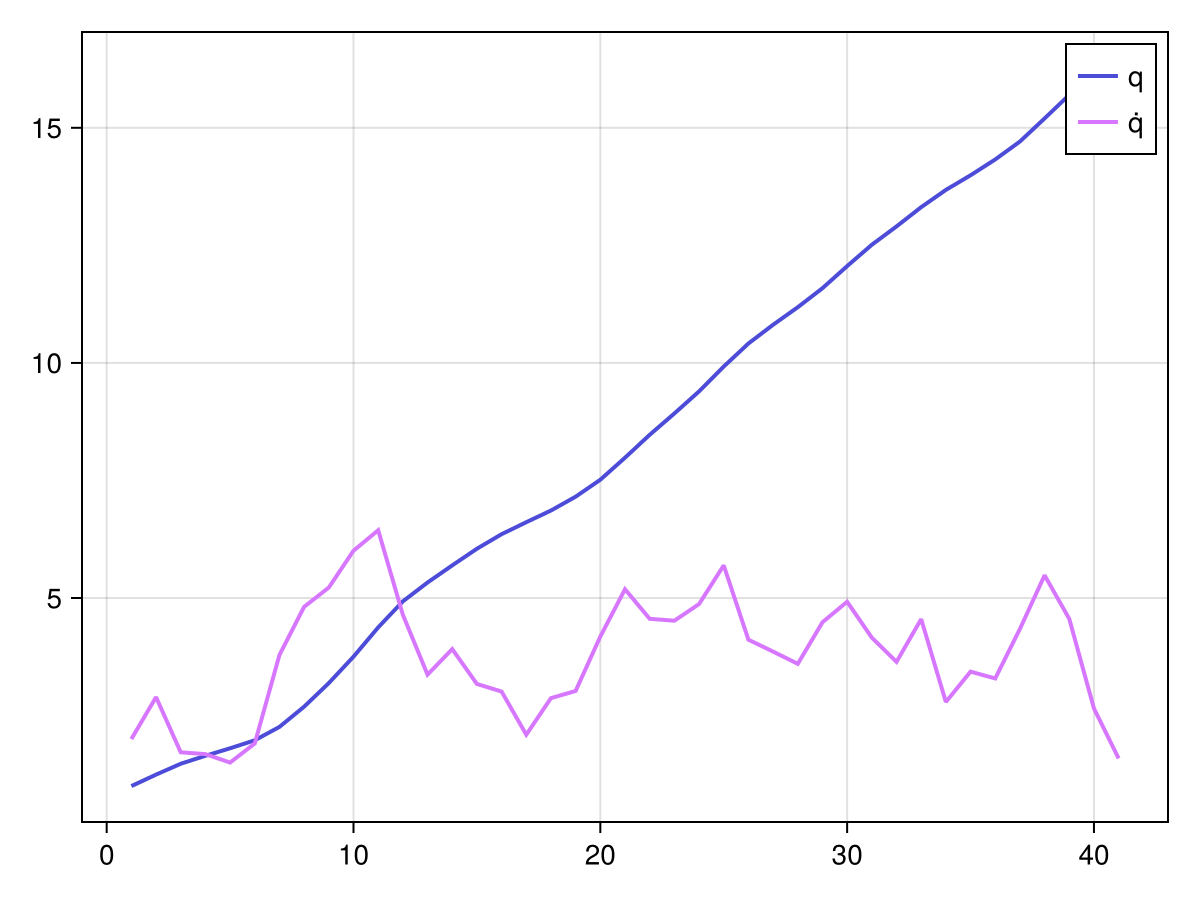

In [211]:
fig, ax = series(simulate_dlti(u0, A, B, x1, h), labels=["q", "q̇"])
axislegend(ax)
fig

In [212]:
res = optimize(u -> J(u; x1=x1, Q=Q, R=R, QN=QN), u0, GradientDescent())

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.604901e+00

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 1.77e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.92e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-04 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.65e-05 ≰ 0.0e+00
    |g(x)|                 = 7.27e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    3005
    ∇f(x) calls:   3005


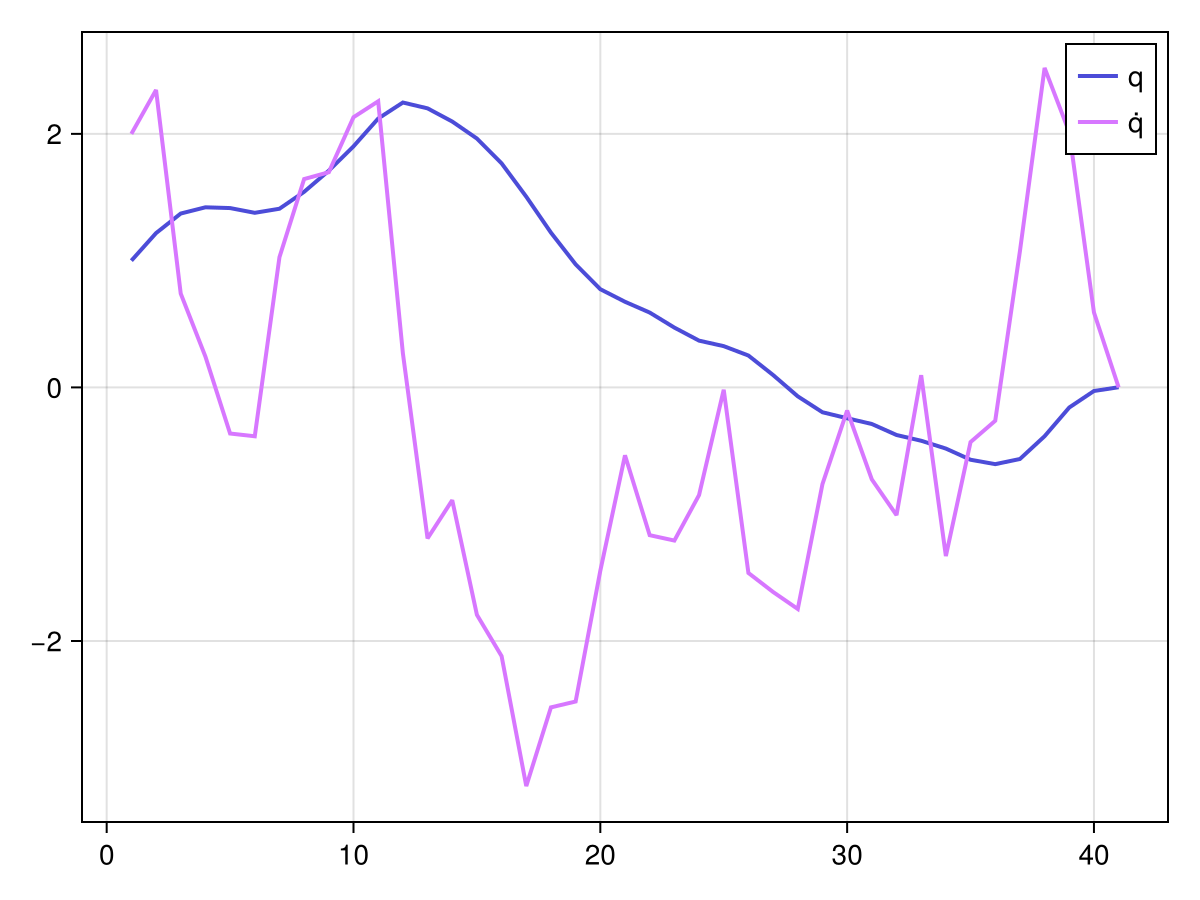

In [213]:
fig, ax = series(simulate_dlti(res.minimizer, A, B, x1, h), labels=["q", "q̇"])
axislegend(ax)
fig

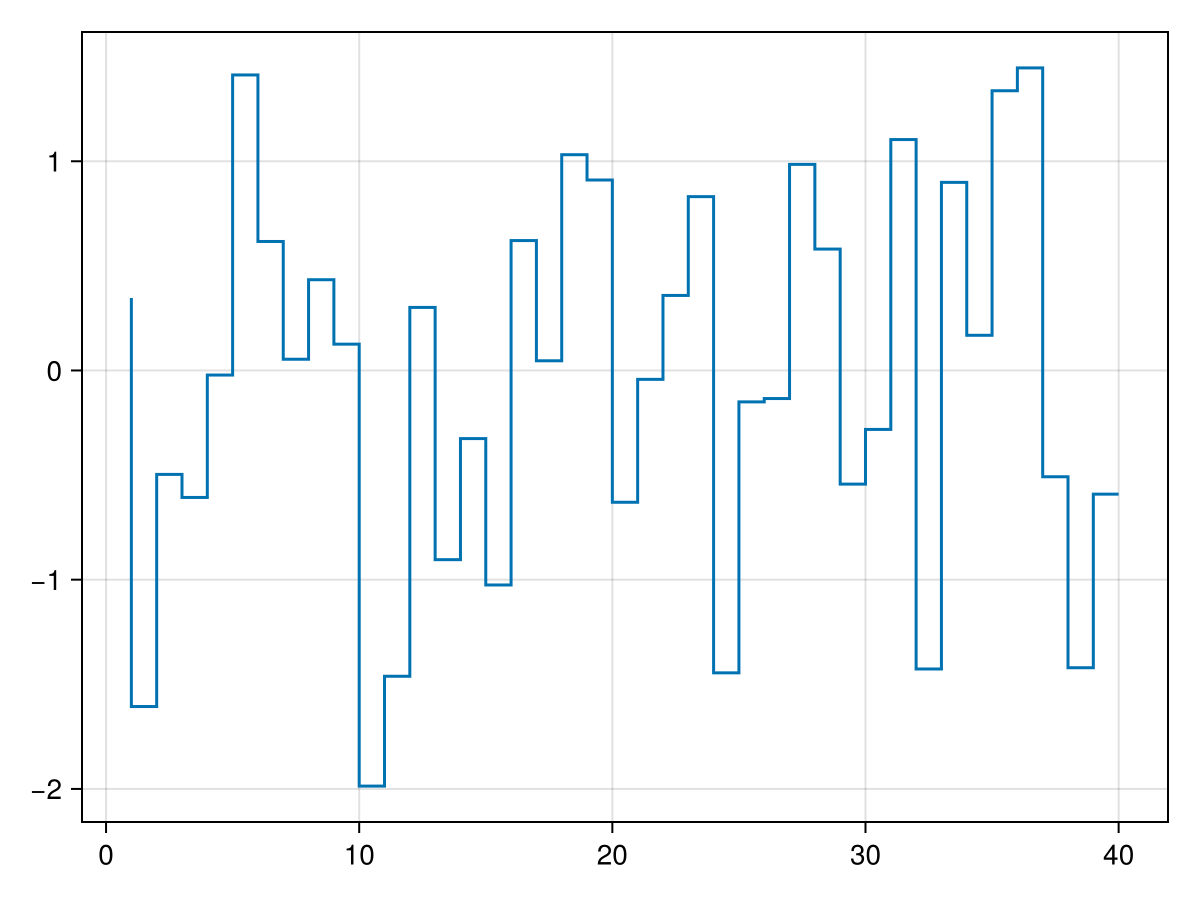

In [214]:
stairs(res.minimizer)

### Newton's method

In [215]:
res_newton = optimize(u -> J(u; x1=x1, Q=Q, R=R, QN=QN), u0, Newton())

 * Status: success

 * Candidate solution
    Final objective value:     3.339026e-02

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 1.61e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.19e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.75e-05 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.42e-03 ≰ 0.0e+00
    |g(x)|                 = 3.55e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    6
    ∇f(x) calls:   6
    ∇²f(x) calls:  2


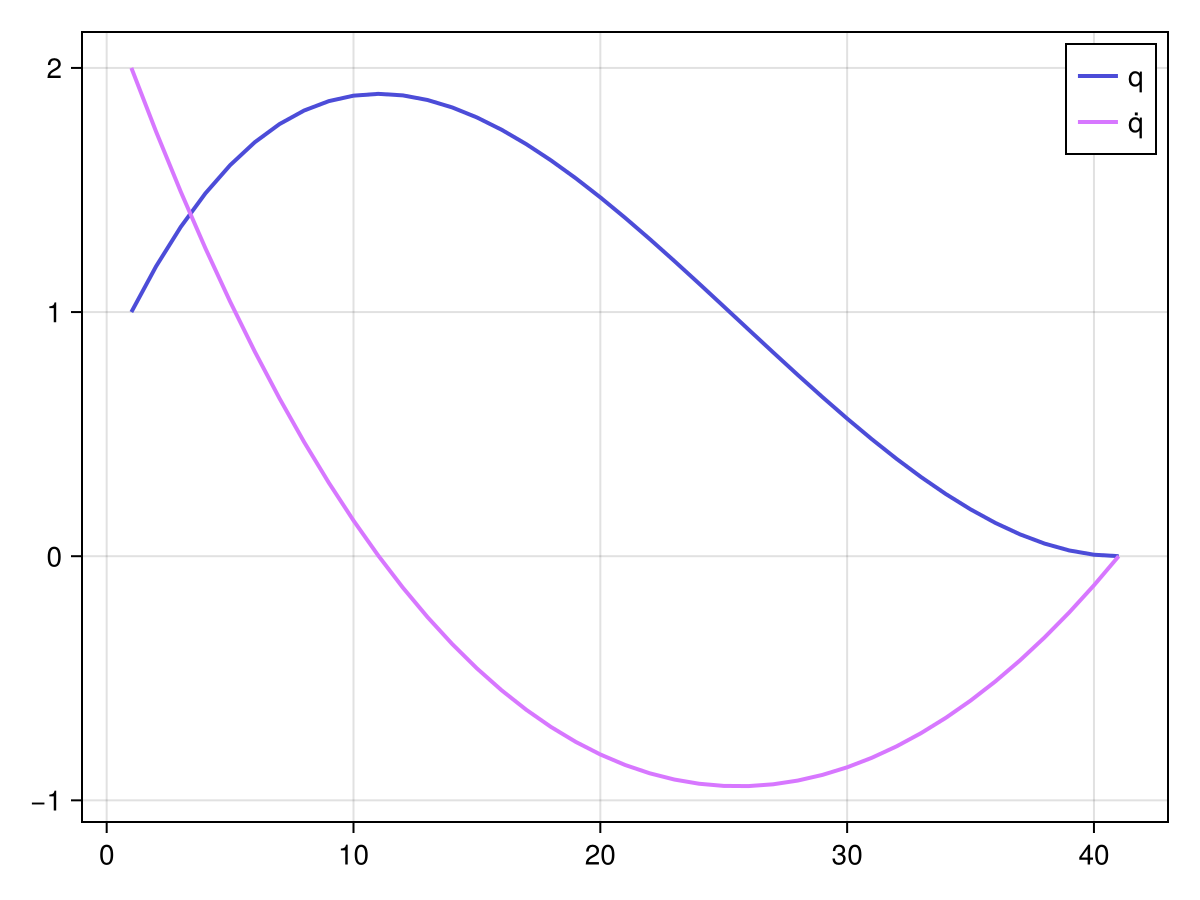

In [216]:
fig, ax = series(simulate_dlti(res_newton.minimizer, A, B, x1, h), labels=["q", "q̇"])
axislegend(ax)
fig

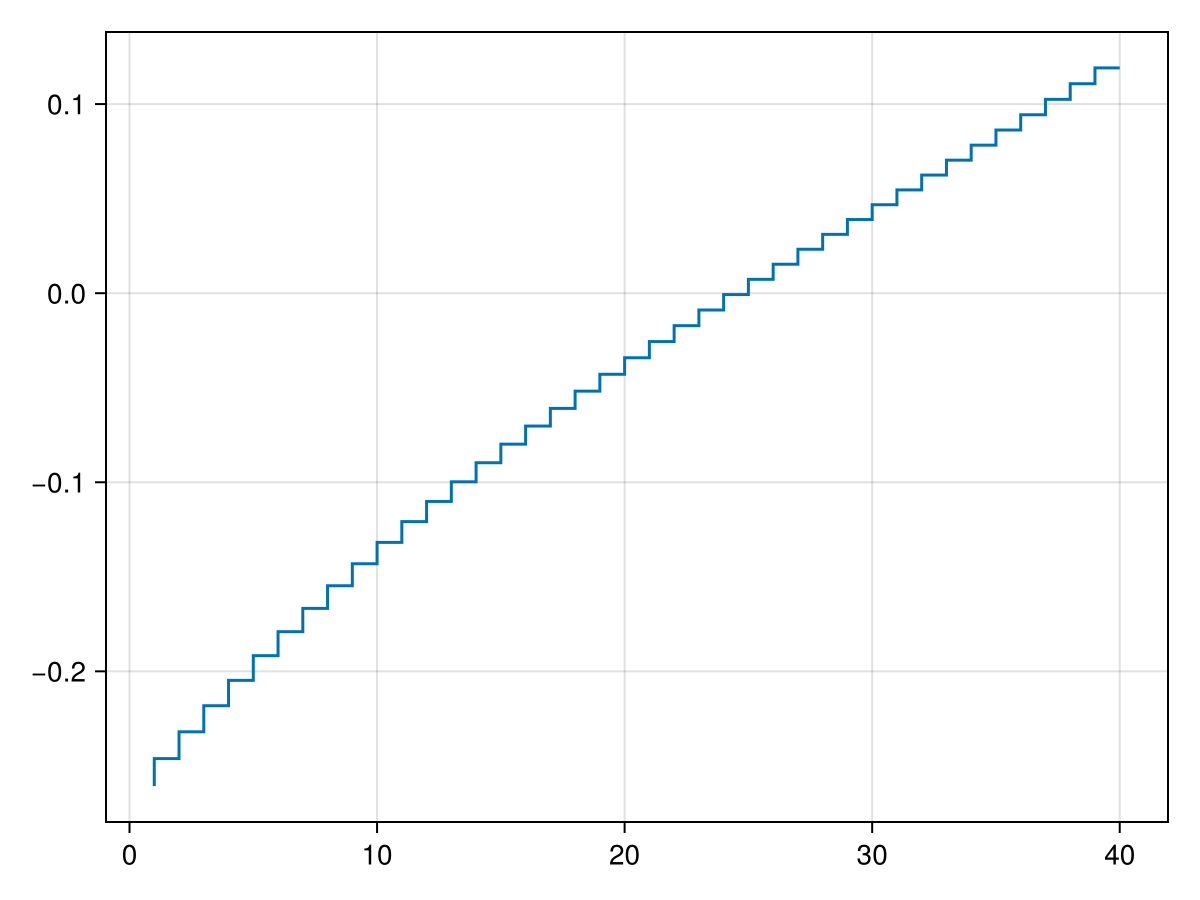

In [217]:
stairs(res_newton.minimizer)

## Indirect optimal control: Apply KKT

- Use KKT conditions because we have a constraint
- We can this in a smart way using the temporal structure of the problem

\begin{align}
\min_{x_{1:N}, u_{1:N}} &\quad J = \sum_{n=1}^N \tfrac{1}{2} x_n^T Q_n x_n + \tfrac{1}{2} u_n^T R_n u_n + \tfrac{1}{2} x_N^T Q_N x_N \\
\text{s.t.} &\quad x_{n+1} = A_n x_n + B_n u_n \\
&\quad Q_n \succeq 0,\, R_n \succ 0
\end{align}



In [ ]:
m = 0.1 # Mass
A_c, B_c = double_integrator(m)
h = 0.1  # Time step
A, B = continuous_to_discrete(A_c, B_c, h)
x1 = [1.0; 1.0]  # Initial state

Q = 1e-4I
R = 1e-1I
QN = 1e2I

UniformScaling{Float64}
100.0*I

## Direct optimal control

- Package the optimization variables into a trajectory
- Set up a quadratic program defined over the trajectory
- Observe the presence of sparsity

\begin{align}
\min_{x_{1:N}, u_{1:N}} &\quad J = \sum_{n=1}^N \tfrac{1}{2} x_n^T Q_n x_n + \tfrac{1}{2} u_n^T R_n u_n + \tfrac{1}{2} x_N^T Q_N x_N \\
\text{s.t.} &\quad x_{n+1} = A_n x_n + B_n u_n \\
&\quad Q_n \succeq 0,\, R_n \succ 0
\end{align}

In [219]:
m = 0.1 # Mass
A_c, B_c = double_integrator(m)
h = 0.1  # Time step
A, B = sparse.(continuous_to_discrete(A_c, B_c, h))
x1 = [1.0; 1.0]  # Initial state

N = 20
x_dim = size(A, 2)
u_dim = size(B, 2)

Q = sparse(1e-4I(x_dim))
R = sparse(1e-2I(u_dim))
QN = sparse(1e2I(x_dim))

2×2 SparseMatrixCSC{Float64, Int64} with 2 stored entries:
 100.0     ⋅ 
    ⋅   100.0

Define 
\begin{align}
Z &= \begin{bmatrix} 
    x_1 & x_2 & \cdots & x_N \\
    u_1 & u_2 & \cdots & u_N 
\end{bmatrix} \\
\Rightarrow \vec{Z} &= \begin{bmatrix} x_1 \\ u_1 \\ x_2 \\ u_2 \\ \vdots \\ x_N \\ u_N \end{bmatrix}
\end{align}
and drop the first state (known) and last control (not used),
\begin{equation}
 z = \vec{Z}[\text{length}(x_1){:}\text{end}{-}\text{length}(u_N)]
\end{equation}

In [220]:
z_dim = (N-2) * (x_dim + u_dim) + u_dim + x_dim

57

Write the cost function as $J = \tfrac{1}{2} z^T H z$, where
\begin{equation}
    H = \begin{bmatrix}
        R_1 & 0 & 0 & & 0 \\
        0 & Q_2 & 0 & \cdots & 0 \\
        0 & 0 & R_2 & & 0 \\
        & \vdots & & \ddots & \vdots \\
        0 & 0 & 0 & \cdots & Q_N \\
    \end{bmatrix}.
\end{equation}

In [221]:
# Recall our shorthand for kron
H = blockdiag(sparse(R), I(N-2) ⊗ blockdiag(sparse(Q), sparse(R)), sparse(QN))

57×57 SparseMatrixCSC{Float64, Int64} with 57 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⎦

Write the dynamics constraint, $Cz = d$, where
\begin{equation}
C = \begin{bmatrix}
    -B_1 & I & 0 & 0 & & 0 \\
    0 & -A_2 & -B_2 & I & \cdots & 0 \\
    \vdots & \vdots & \ddots & \ddots & \ddots & 0 \\
    0 & 0 & \cdots & -A_{N-1} & -B_{N-1} & I
\end{bmatrix}, \qquad
d = \begin{bmatrix}
    A_1 x_1 \\
    0 \\
    0 \\
    \vdots \\
    0
\end{bmatrix}
\end{equation}


In [222]:
C = I(N-1) ⊗ [-B I(x_dim)]
for k = 1:N-2
    C[(k * x_dim) .+ (1:x_dim), (k * (x_dim + u_dim) - x_dim) .+ (1:x_dim)] = -A
end
C

38×57 SparseMatrixCSC{Float64, Int64} with 130 stored entries:
⎡⠫⣦⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠙⠫⣦⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠙⠫⣦⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠙⠫⣦⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠫⣦⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠫⣦⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠫⣦⢄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠫⣦⢄⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠫⣦⢄⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠋⠂⎦

In [223]:
# Check the structure of C
k = 6
(
    C[(k * x_dim) .+ (1:x_dim), (k * (x_dim + u_dim) - x_dim) .+ (1:(2x_dim + u_dim))] 
    == [-A -B I(x_dim)]
)

true

In [224]:
d = [A * x1; zeros((N-2) * x_dim)];

Putting it all together, 
\begin{align}
    \min_z &\quad \tfrac{1}{2} z^T H z \\
    \text{s.t.}&\quad C z = d
\end{align}

- Lagrangian:
\begin{equation}
    L(z, \lambda) = \tfrac{1}{2} z^T H z + \lambda^T (C z - d)
\end{equation}

- KKT conditions:
\begin{align}
    & \nabla_z L = H z + C^T \lambda \overset{!}{=} 0 \\
    & \nabla_\lambda L = Cz - d \overset{!}{=} 0 \\
\end{align}

- Matrix form:
\begin{equation}
    \Rightarrow \begin{bmatrix} H & C^T \\ C & 0 \end{bmatrix} 
    \begin{bmatrix} z \\ \lambda \end{bmatrix} 
    = \begin{bmatrix} 0 \\ d \end{bmatrix}
\end{equation}

- How many iterations will this take to solve?

In [225]:
P = [H C'; C zeros(size(C, 1), size(C, 1))]

95×95 SparseMatrixCSC{Float64, Int64} with 317 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠫⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣣⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢻⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢷⡀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢵⡄⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠹⣇⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⡶⡀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢿⡄⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢺⣆⡀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⣧⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢗⎥
⎢⠫⢦⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠉⠺⣦⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠻⣦⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠙⠳⢖⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠷⢦⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠫⣦⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠺⢶⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠛⢵⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦

In [226]:
res_qp = P \ [zeros(z_dim); d]

# Extract the minimizer
z_minimizer = res_qp[1:z_dim]
u_minimizer = z_minimizer[1:x_dim + u_dim:end];

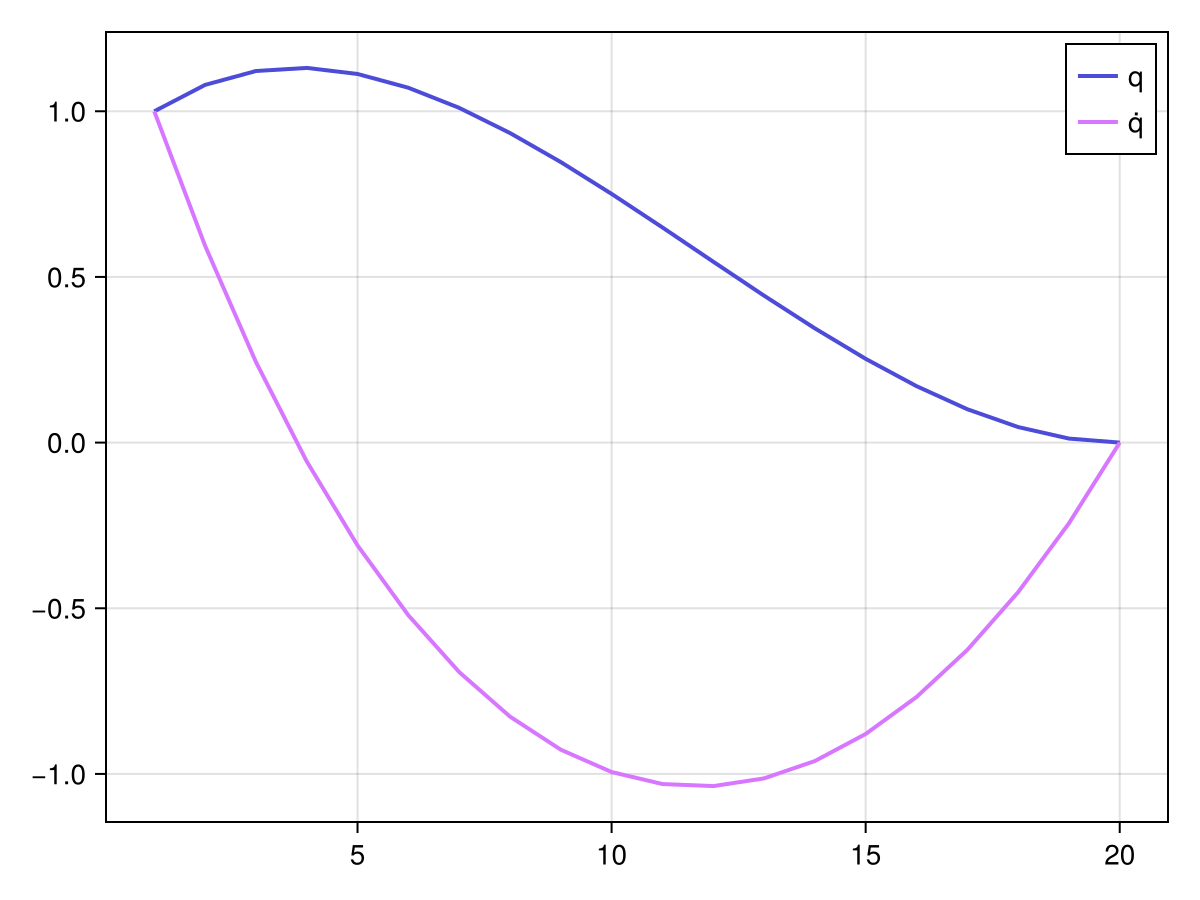

In [227]:
fig, ax = series(simulate_dlti(u_minimizer, A, B, x1, h), labels=["q", "q̇"])
axislegend(ax)
fig

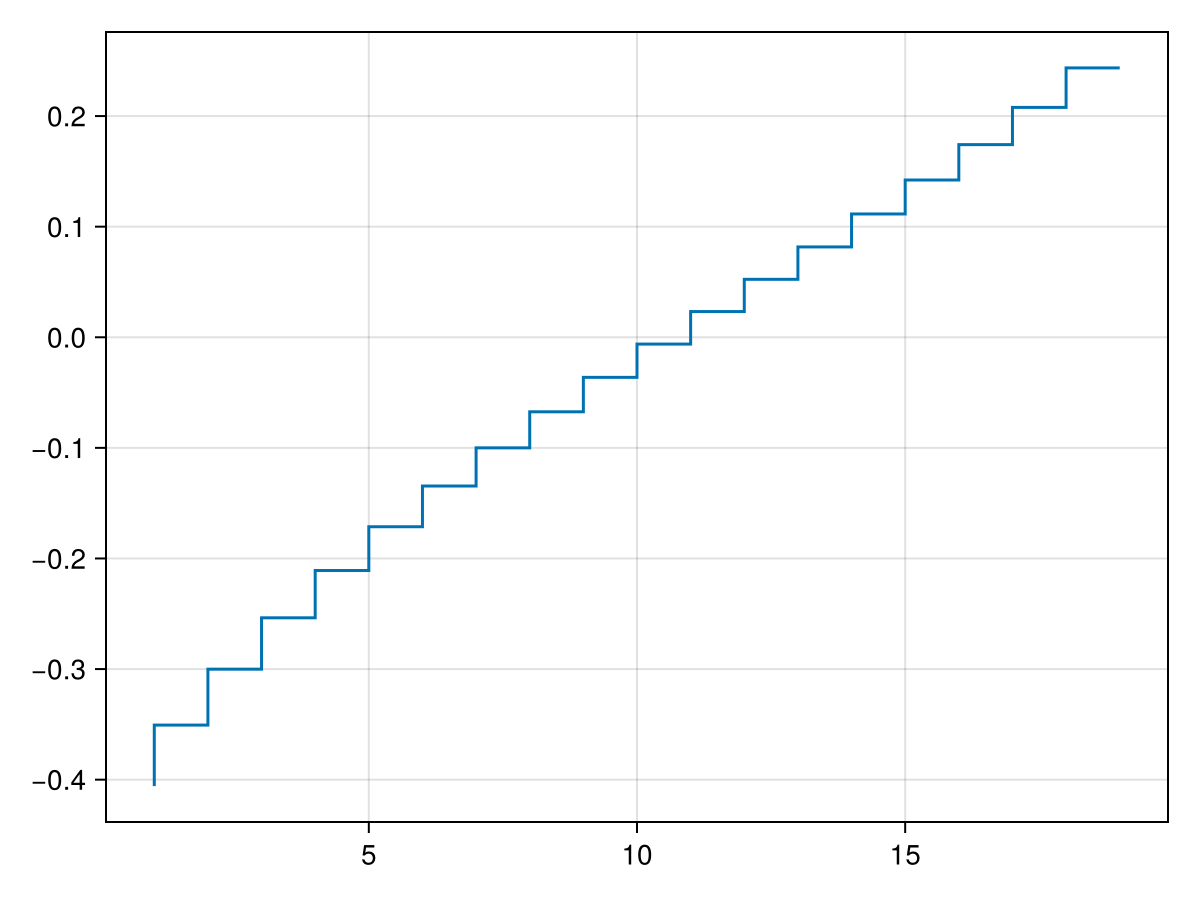

In [228]:
stairs(u_minimizer)

# III. Any last topics?
-----

- could teach DARE
- could mention nonlinear or leave for exercises